Tutorial Credit: https://blog.keras.io/building-autoencoders-in-keras.html

Let's build the simplest possible autoencoder

In [2]:
import keras
from keras import layers

#This is the size of our encoded representations
encoding_dim = 32 #32 floats -> compression of factor 24.5, assuming the input is 784 floats 

#This is our input image
input_img = keras.Input(shape = (784,))

#"encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation = 'relu')(input_img)

#"decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation = 'sigmoid')(encoded)

#This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model: 

In [3]:
#This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Let's also create a separate decoder model:

In [4]:
#This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape = (encoding_dim,))

#Retrieve the las layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

#Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits. 

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer: 

In [5]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(xtrain, _), (xtest, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [7]:
xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xtrain = xtrain.reshape((len(xtrain), np.prod(xtrain.shape[1:])))
xtest = xtest.reshape((len(xtest), np.prod(xtest.shape[1:])))
print(xtrain.shape)
print(xtest.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs: 

In [19]:
autoencoder.fit(xtrain, xtrain,
               epochs = 50,
               batch_size = 256,
               shuffle = True,
               validation_data = (xtest, xtest))

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.3822 - val_loss: 0.1872
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1782 - val_loss: 0.1538
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1494 - val_loss: 0.1338
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1313 - val_loss: 0.1210
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1201 - val_loss: 0.1127
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1125 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1073 - val_loss: 0.1029
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1031 - val_loss: 0.0996
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1003 - val_loss: 0.0973
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0980 - val_loss: 0.0956

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructioned inputs and the enconded representations. We will use Matplotlib.

In [8]:
#Encode and decode some digits
#Note that we take them from the *test* set
encoded_imgs = encoder.predict(xtest)
decoded_imgs = decoder.predict(encoded_imgs)

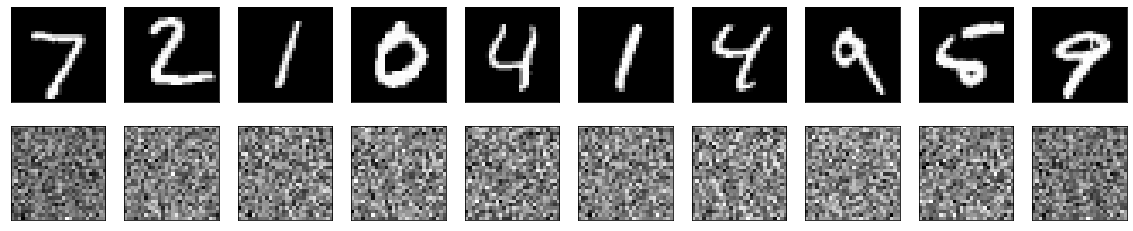

In [9]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xtest[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.



#Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [11]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))

# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Let's train this model for 100 epochs:

In [13]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

autoencoder.fit(xtrain, xtrain,
               epochs = 100,
               batch_size = 256,
               shuffle = True,
               validation_data = (xtest, xtest))

Epoch 1/100
235/235 [==============================] - 8s 5ms/step - loss: 0.3933 - val_loss: 0.2015
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1908 - val_loss: 0.1631
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1590 - val_loss: 0.1440
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1422 - val_loss: 0.1326
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1319 - val_loss: 0.1250
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1249 - val_loss: 0.1188
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1184 - val_loss: 0.1143
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1147 - val_loss: 0.1112
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1117 - val_loss: 0.1088
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1096 - val_lo

The model finishes with a loss function of 0.1 and a validation loss of 0.1

#Deep autoencoder


We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:



In [20]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

Let's try this: 

In [22]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(xtrain, xtrain,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(xtest, xtest))

Epoch 1/100
235/235 [==============================] - 2s 5ms/step - loss: 0.3455 - val_loss: 0.1694
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1601 - val_loss: 0.1372
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1342 - val_loss: 0.1248
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1251 - val_loss: 0.1186
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1188 - val_loss: 0.1134
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1136 - val_loss: 0.1093
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1103 - val_loss: 0.1068
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1079 - val_loss: 0.1049
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1057 - val_loss: 0.1034
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1037 - val_lo

After 100 epochs, it reaches a train and validation loss of ~0.08, a bit better than our previous models.

#Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.



In [23]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.



In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step
